# Peteris ir vilkas: realistiška aplinka

Mūsų situacijoje Peteris galėjo judėti beveik be nuovargio ar alkio. Daugiau realistiškame pasaulyje jis turėtų kartais atsisėsti ir pailsėti, taip pat pasimaitinti. Padarykime mūsų pasaulį realistiškesnį, įgyvendindami šias taisykles:

1. Judėdamas iš vienos vietos į kitą, Peteris praranda **energiją** ir įgyja **nuovargį**.
2. Peteris gali padidinti energiją valgydamas obuolius.
3. Peteris gali atsikratyti nuovargio ilsėdamasis po medžiu arba ant žolės (t. y. įžengdamas į lentos vietą su medžiu arba žole - žalią lauką).
4. Peteris turi surasti ir nužudyti vilką.
5. Kad nužudytų vilką, Peteris turi turėti tam tikrą energijos ir nuovargio lygį, kitaip jis pralaimės kovą.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

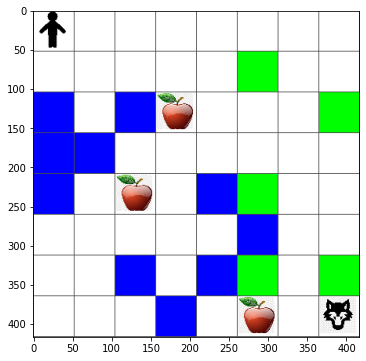

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Apibrėžiant būseną

Pagal naujas žaidimo taisykles, turime stebėti energiją ir nuovargį kiekvienoje lentos būsenoje. Todėl sukursime objektą `state`, kuris saugos visą reikalingą informaciją apie dabartinę problemos būseną, įskaitant lentos būseną, dabartinius energijos ir nuovargio lygius, bei tai, ar galime nugalėti vilką galutinėje būsenoje:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Pabandykime išspręsti problemą naudojant atsitiktinį ėjimą ir pažiūrėkime, ar mums pavyks:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Apdovanojimo funkcija

### Apžvalga
Apdovanojimo funkcija yra pagrindinis komponentas, kuris nustato agento elgesį mokymosi procese. Ji suteikia grįžtamąjį ryšį, leidžiantį agentui suprasti, ar jo veiksmai buvo tinkami, ar ne.

### Tikslas
Apdovanojimo funkcijos tikslas yra paskatinti agentą siekti norimo rezultato, tuo pačiu išvengiant nepageidaujamų veiksmų. Ji turėtų būti kruopščiai sukurta, kad užtikrintų efektyvų mokymąsi.

### Pagrindiniai principai
- **Aiškumas**: Apdovanojimo funkcija turėtų būti aiški ir lengvai suprantama agentui.
- **Subalansuotumas**: Ji turėtų tinkamai atspindėti norimus ir nepageidaujamus veiksmus.
- **Skatinimas**: Apdovanojimai turėtų motyvuoti agentą siekti optimalaus sprendimo.

### Pavyzdys
Toliau pateikiamas apdovanojimo funkcijos pavyzdys:

```python
def reward_function(state, action):
    if action == "desired_action":
        return 10  # Suteikiamas teigiamas apdovanojimas
    elif action == "undesired_action":
        return -5  # Suteikiamas neigiamas apdovanojimas
    else:
        return 0  # Neutralus apdovanojimas
```

### Dažnos klaidos
- **Per sudėtinga funkcija**: Jei apdovanojimo funkcija yra per sudėtinga, agentui gali būti sunku suprasti, kaip pasiekti norimą rezultatą.
- **Netinkamas balansas**: Jei apdovanojimai ir baudos nėra tinkamai subalansuoti, agentas gali išmokti netinkamą elgesį.
- **Nepakankamas grįžtamasis ryšys**: Jei apdovanojimo funkcija nesuteikia pakankamai informacijos, mokymosi procesas gali būti neefektyvus.

### Patarimai
- Pradėkite nuo paprastos apdovanojimo funkcijos ir palaipsniui ją tobulinkite.
- Testuokite funkciją įvairiose situacijose, kad įsitikintumėte, jog ji veikia taip, kaip tikėtasi.
- Naudokite vizualizacijas, kad stebėtumėte agento mokymosi procesą ir identifikuotumėte galimas problemas.

### Išvada
Apdovanojimo funkcija yra esminis mokymosi proceso elementas, kuris tiesiogiai veikia agento elgesį. Kruopščiai sukurta funkcija gali žymiai pagerinti mokymosi efektyvumą ir pasiekti norimus rezultatus.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning algoritmas

Pats mokymosi algoritmas iš esmės nesikeičia, mes tiesiog naudojame `state` vietoj vien tik lentos pozicijos.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

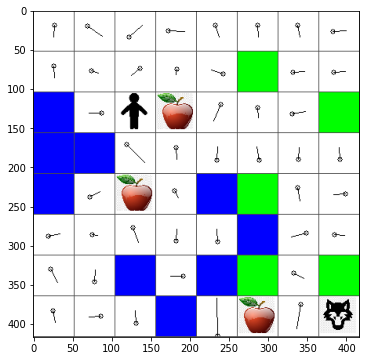

In [11]:
m.plot(Q)

## Rezultatai

Pažiūrėkime, ar mums pavyko išmokyti Peterį kovoti su vilku!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Dabar matome daug mažiau skendimo atvejų, tačiau Peteris vis dar ne visada sugeba nužudyti vilką. Pabandykite eksperimentuoti ir pažiūrėkite, ar galite pagerinti šį rezultatą žaisdami su hiperparametrais.


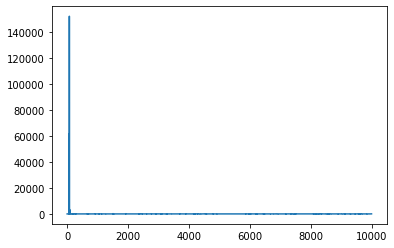

In [13]:
plt.plot(lpath)


---

**Atsakomybės apribojimas**:  
Šis dokumentas buvo išverstas naudojant AI vertimo paslaugą [Co-op Translator](https://github.com/Azure/co-op-translator). Nors siekiame tikslumo, prašome atkreipti dėmesį, kad automatiniai vertimai gali turėti klaidų ar netikslumų. Originalus dokumentas jo gimtąja kalba turėtų būti laikomas autoritetingu šaltiniu. Dėl svarbios informacijos rekomenduojama profesionali žmogaus vertimo paslauga. Mes neprisiimame atsakomybės už nesusipratimus ar klaidingus interpretavimus, atsiradusius naudojant šį vertimą.
